# 🚗 <font color='cyan'>**Analyzing NYC Collision Data 🚗**</font>
Authors: Yu-Sheng Lee, Jeremy Cui, Hannah MacDonald<br>
GitHub Repository: https://github.com/UC-Berkeley-I-School/project2_lee_cui_macd/<br>
Primary Dataset: [NYC OpenData Motor Vehicle Collisions - Crashes dataset](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95)

# 1. Sanity Check and Initial Data Cleaning

In [ ]:
# standard library
import datetime
import IPython.display as display

# data analysis
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Read in the data
data = pd.read_csv("/Users/yu-shenglee/Desktop/dev/mids-datasci200-fall24-Yusheng-Lee/Project 2/data/Motor_Vehicle_Collisions_-_Crashes_20241124.csv", 
                   dtype={'ZIP CODE':str}, 
                   parse_dates=[ 'CRASH DATE','CRASH TIME'])

# Rename column names
data.columns = [column.lower().replace(' ','_') for column in data.columns]

# Fix inconsistent Upper and Lower Cases in the vehicle type code columns
data['vehicle_type_code_1'] = data['vehicle_type_code_1'].str.lower() 
data['vehicle_type_code_2'] = data['vehicle_type_code_2'].str.lower() 
data['vehicle_type_code_3'] = data['vehicle_type_code_3'].str.lower()
data['vehicle_type_code_4'] = data['vehicle_type_code_4'].str.lower() 
data['vehicle_type_code_5'] = data['vehicle_type_code_5'].str.lower() 


## An Overview of the Numerical Columns

1. Latitude & Longitude: The latitude and longitude indicate where the crashes are occurring. However, there are some data points with latitude and longitude values of 0, which is likely due to missing or inaccurate data.

2. Number of Persons Injured: On average, each crash has around 0.318 injuries. The maximum number of injuries in a single crash is 43.

3. Number of Persons Killed: Fatalities are rare, with an average of 0.00154 deaths per crash. The maximum number of deaths in one crash is 8.

4. Number of Pedestrians, Cyclists, and Motorists Injured/Killed: These columns provide a breakdown of the injuries and fatalities by type of individual involved.

5. Collision ID: This is a unique identifier for each crash.

In [42]:
data.describe()

,latitude,longitude,number_of_persons_injured,number_of_persons_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,collision_id
count,1.896966e+06,1.896966e+06,2.136361e+06,2.136348e+06,2.136379e+06,2.136379e+06,2.136379e+06,2.136379e+06,2.136379e+06,2.136379e+06,2.136379e+06
mean,4.062494e+01,-7.374707e+01,3.182032e-01,1.539075e-03,5.770839e-02,7.592286e-04,2.787708e-02,1.207651e-04,2.284543e-01,6.347188e-04,3.204786e+06
std,2.007794e+00,3.767273e+00,7.071337e-01,4.141880e-02,2.463473e-01,2.811551e-02,1.667368e-01,1.103117e-02,6.683430e-01,2.756378e-02,1.506748e+06
min,0.000000e+00,-2.013600e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.200000e+01
25%,4.066759e+01,-7.397471e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.170214e+06
50%,4.072060e+01,-7.392710e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.704452e+06
75%,4.076963e+01,-7.386677e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.238780e+06
max,4.334444e+01,0.000000e+00,4.300000e+01,8.000000e+00,2.700000e+01,6.000000e+00,4.000000e+00,2.000000e+00,4.300000e+01,5.000000e+00,4.773181e+06


## An Overview of the Missing Values

- Columns like `vehicle_type_code_5`, `contributing_factor_vehicle_5`, `vehicle_type_code_4`, and so on have a high percentage of missing values. This is expected since not all crashes involve multiple vehicles or factors.

- `off_street_name` and `cross_street_name` have significant missing values. This could be due to crashes occurring in locations where these details aren't applicable or weren't recorded.

- `zip_code` and `borough` also have missing values. This might be due to incomplete data entry or crashes occurring in areas where these specifics aren't easily determinable.

- `location`, `latitude`, and `longitude` have the same count of missing values, indicating that when one is missing, the others are likely missing as well.


In [43]:
missing_values = data.isnull().sum()
missing_values_percentage = (missing_values / len(data)) * 100
missing_data = pd.DataFrame({'Missing Values': missing_values, 'Percentage (%)': missing_values_percentage})
missing_data.sort_values(by='Percentage (%)', ascending=False)

,Missing Values,Percentage (%)
vehicle_type_code_5,2127150,99.568007
contributing_factor_vehicle_5,2126855,99.554199
vehicle_type_code_4,2102690,98.423079
contributing_factor_vehicle_4,2101442,98.364663
vehicle_type_code_3,1988458,93.076088
contributing_factor_vehicle_3,1982698,92.806473
off_street_name,1770715,82.883936
cross_street_name,814486,38.124602
zip_code,663784,31.070517
borough,663522,31.058253


# 2. Descriptive Statistics of the Data

## 2.1 The Top 3 Contributing Factors to Crashes
Besides for "Unspecified," the top 3 contributing factors are:
> * Driver Inattention/Distraction
> * Failure to Yield Right-of-Way
> * Following Too Closely

Maybe drivers should avoid using cell phones while driving

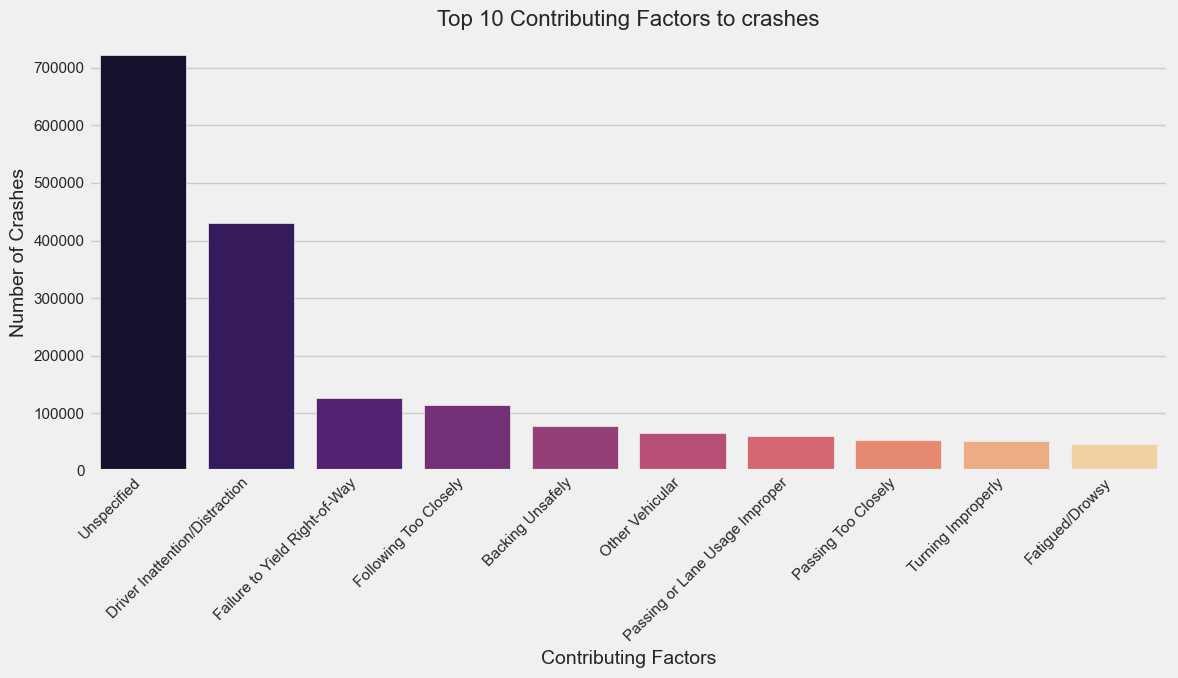

In [44]:
top_factors = data['contributing_factor_vehicle_1'].value_counts().head(10)

plt.figure(figsize=(12, 7))
sns.barplot(x=top_factors.index, y=top_factors.values, palette="magma")
plt.title('Top 10 Contributing Factors to crashes', fontsize=16)
plt.xlabel('Contributing Factors', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 2.2 The Top 3 Vehicle Types to Crashes
Top 3 vehicles that were most involved in crashes are:
> * Sedan
> * Station Wagon/Sport Utility Vehicle
> * Passenger Vehicle

Sedan and SUVs are the most common types of Vehicles in daily use. I would not be surprised seeing them on the list.

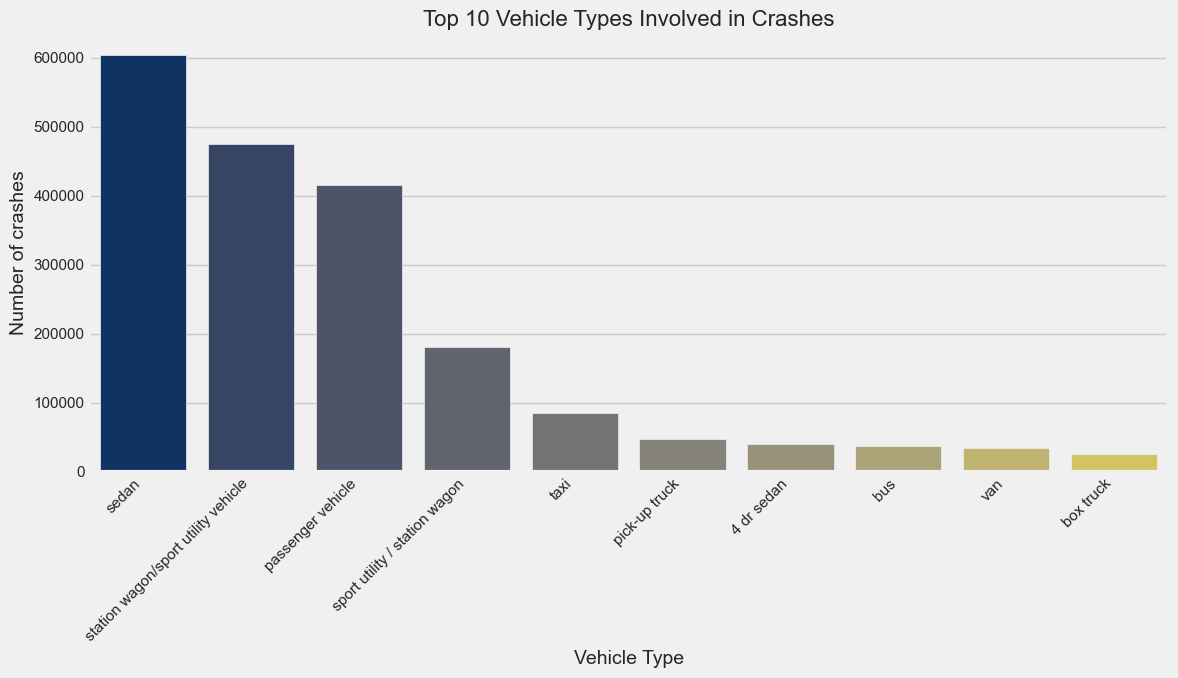

In [45]:
# Determine the top vehicle types involved in crashes
top_vehicle_types = data['vehicle_type_code_1'].value_counts().head(10)

# Plotting the top vehicle types
plt.figure(figsize=(12, 7))
sns.barplot(x=top_vehicle_types.index, y=top_vehicle_types.values, palette="cividis")
plt.title('Top 10 Vehicle Types Involved in Crashes', fontsize=16)
plt.xlabel('Vehicle Type', fontsize=14)
plt.ylabel('Number of crashes', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 2.3 Types of Crashes and Their Frequencies

Motorists Injury is the crash type with highest frequency followed by Pedestrian Injury and Cyclist Injury.

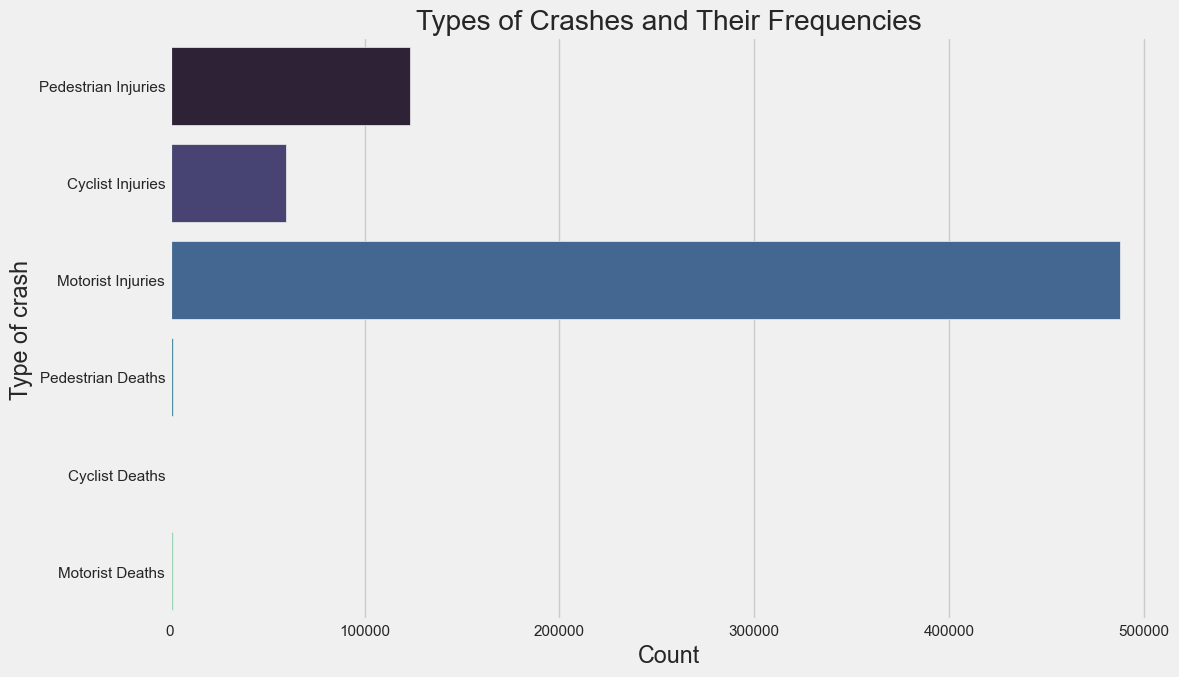

In [46]:
# Aggregating data - Complete for Cyclist and Motorist
types_of_crashes = {
    'Pedestrian Injuries': data['number_of_pedestrians_injured'].sum(),
    'Cyclist Injuries': data['number_of_cyclist_injured'].sum(),
    'Motorist Injuries': data['number_of_motorist_injured'].sum(),
    'Pedestrian Deaths': data['number_of_pedestrians_killed'].sum(),
    'Cyclist Deaths': data['number_of_cyclist_killed'].sum(),
    'Motorist Deaths': data['number_of_motorist_killed'].sum()
}

# Converting to DataFrame for easier plotting - we want the items in the dictionary, use the items function
crash_types_df = pd.DataFrame(list(types_of_crashes.items()), columns=['crash Type', 'Count'])

# Plot
plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='crash Type', data=crash_types_df, palette="mako")
plt.title('Types of Crashes and Their Frequencies')
plt.xlabel('Count')
plt.ylabel('Type of crash')
plt.tight_layout()
plt.show()


# 3. Plotting Against Time

## 3.1 Average Crashes Over the Hours of A Day
After plotting the average crash count against the hours of a day, we can see that the starting from 8 am the count rises up, particularly due to the start of rush hour as people commute to work. It starts to reach the peak during 2 pm to 5 pm, and falls starting from 6 pm. The peak time span is longer, probably because of school dismissal time and rush hour when people get back from work. There is a downtime during 1 am to 4 am as most people are sleeping during that time.

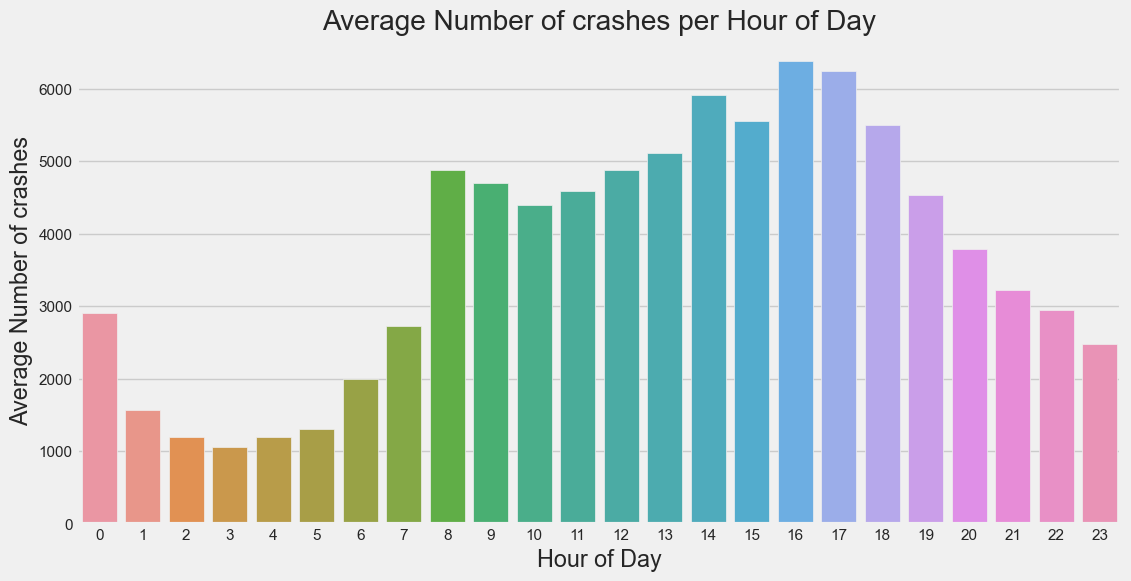

In [47]:
# Time of Day Analysis

# Convert 'crash_date' and 'crash_time' to datetime
data["crash_date"] = pd.to_datetime(data["crash_date"])
data['crash_time'] = pd.to_datetime(data['crash_time'], format='%H:%M')
data['Hour of Day'] = data['crash_time'].dt.hour

# Group by 'Hour of Day' and calculate the average number of crashes per hour
average_crashes_per_hour = data.groupby('Hour of Day').size() / data['Hour of Day'].nunique()

# Plot the average number of crashes
plt.figure(figsize=(12, 6))
sns.barplot(x=average_crashes_per_hour.index, y=average_crashes_per_hour.values)
plt.title('Average Number of crashes per Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of crashes')
plt.xticks(range(0, 24))
plt.show()


## 3.2 Covid-19 Impact

From the below graph plotting number of crashes per month against time, we see there is a big drop during the year of 2020. This is likely because of the COVID-19 pandemic outbreak, and the government imposed a stay-home policy. The graph shows some similar patterns over the year and worth breaking it down using time series analysis.

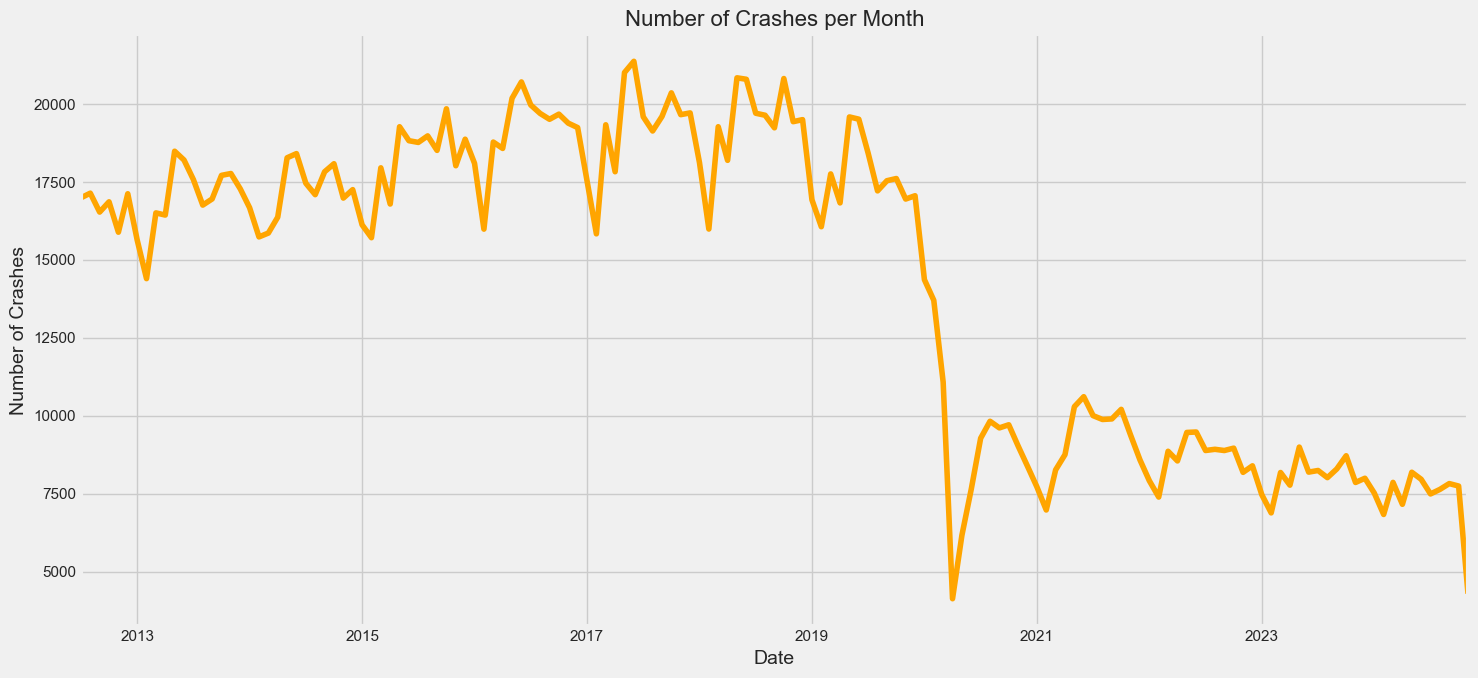

In [69]:
# Group by month and year to get the number of crashes per month
monthly_crashes = data.groupby(data.crash_date.dt.to_period("M")).size()

# Plotting the series against time
plt.figure(figsize=(15, 7))
monthly_crashes.plot(color='orange')

plt.title('Number of Crashes per Month', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Crashes', fontsize=14)
plt.tight_layout()
plt.show()

## 3.3 Time Series Plot

- Number of daily crashes over time

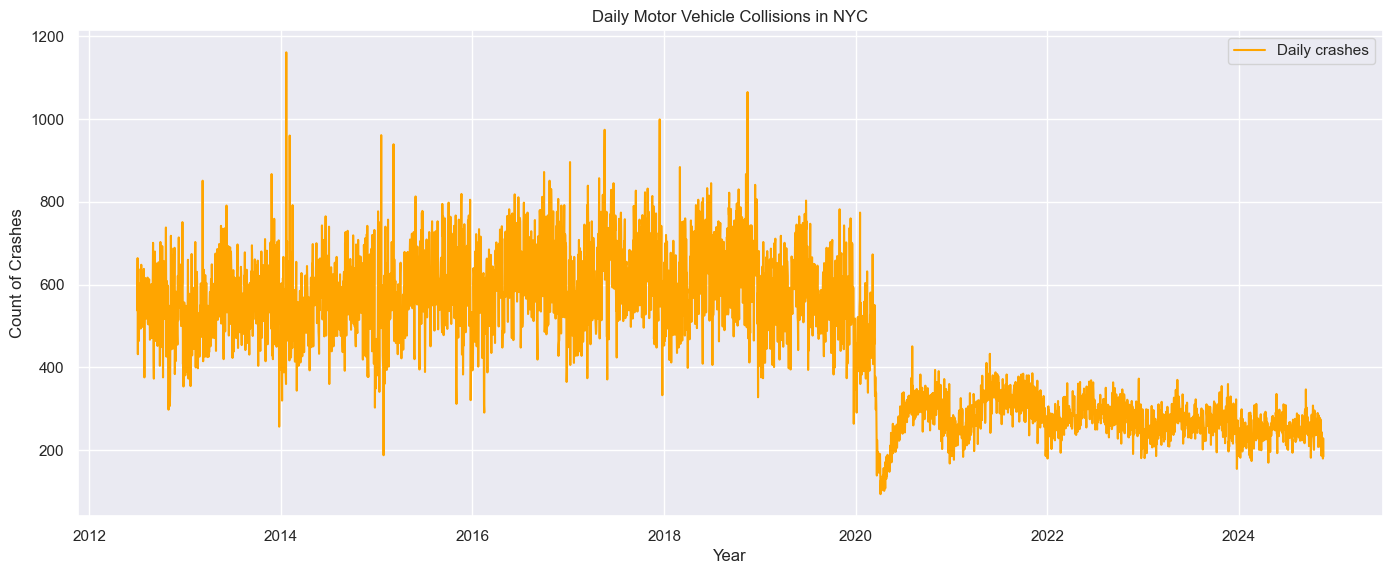

In [70]:
# Count the number of crashes per day, group by CRASH DATE
daily_crashes = data.groupby('crash_date').size()

# Set plot style
sns.set(style="darkgrid")

# Plot the daily crashes time series
plt.figure(figsize=(15, 6))
plt.plot(daily_crashes, label='Daily crashes', color='Orange')
plt.title('Daily Motor Vehicle Collisions in NYC')
plt.xlabel('Year')
plt.ylabel('Count of Crashes')
plt.legend()
plt.show()

- We can further decompose this time series graph into 3 components:  
    - Trend: This graph shows the long-term trend in the data. The crash frequency slightly trends upwards from 2014. Starting from 2020, it decreased sharply because of the outbreak of Covid-19 and the stay-at-home policy. It got back a little bit; however, remains low and stable going forward.
    - Seasonality: We can see there is a yearly seasonality from this graph where during the summer time and closer to the end of the year, the crash frequency tends to be higher. It is probably because of holidy seasons during summer vacations and year end holidays such as Thanksgiving, Christmas, and New Year.
    - Residuals: The residual graph shows random or unpredictable fluctuations. The magnitude of fluctuations drops during the year of 2020, reflecting the same Covid-19 effect as the trend graph.
    

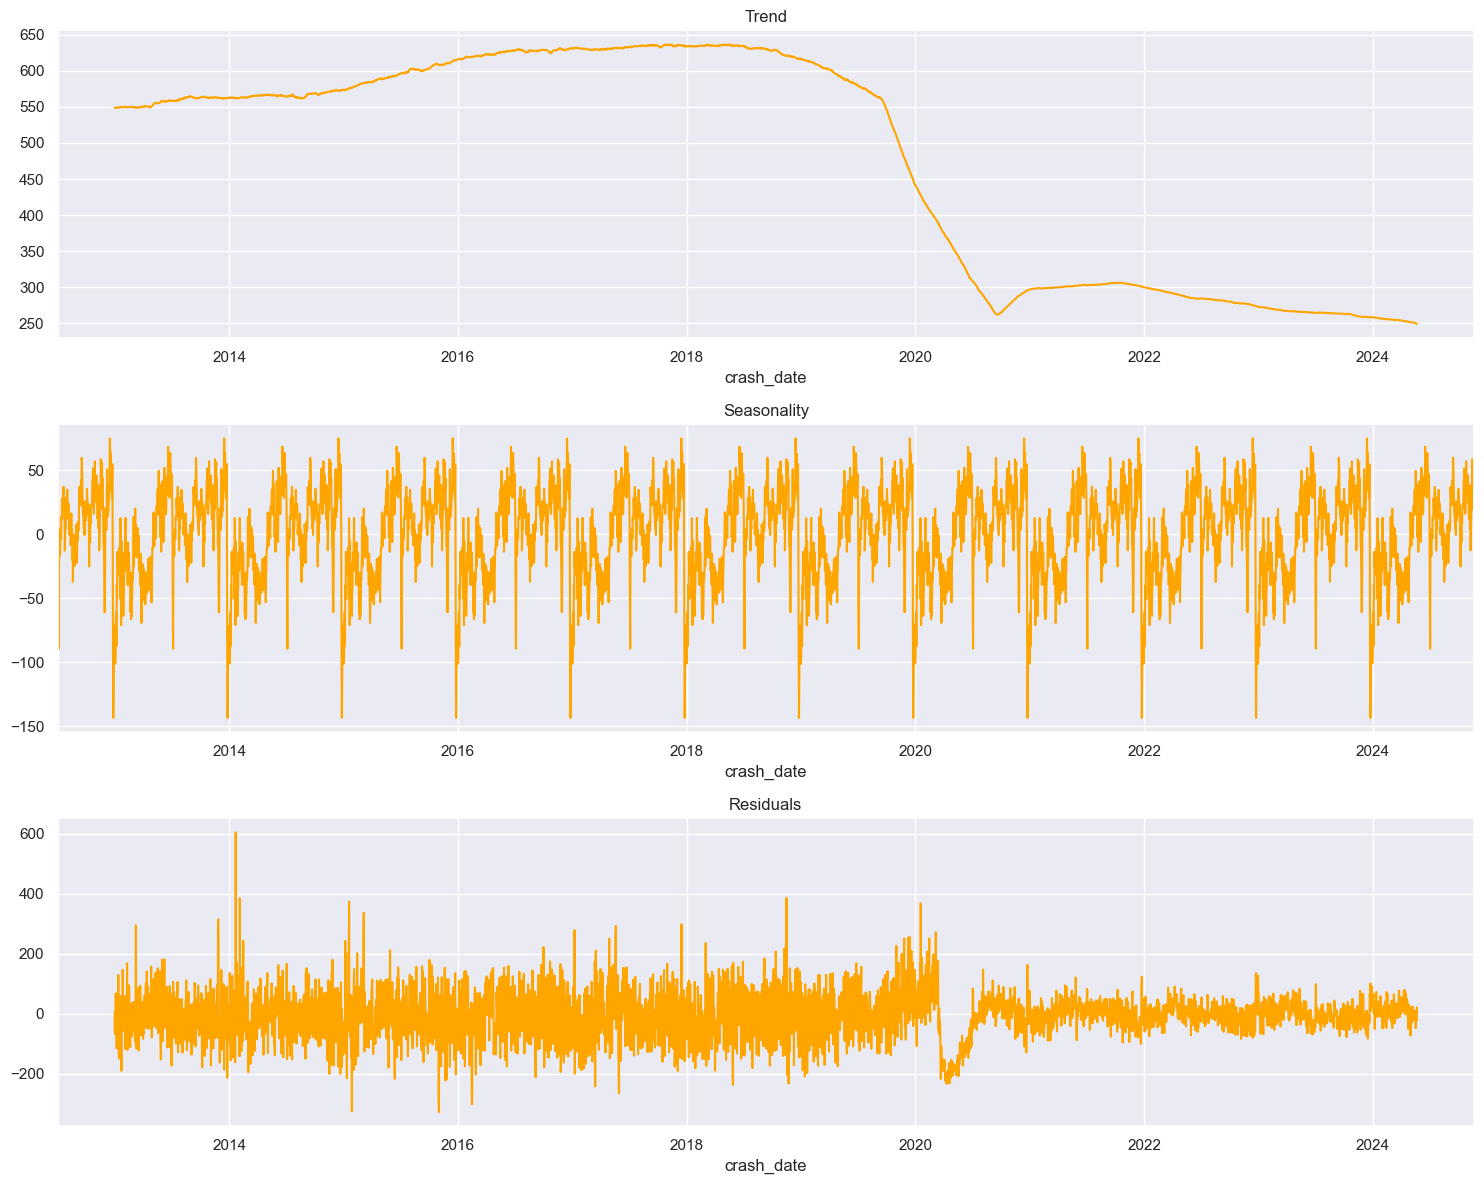

In [71]:
# Decompose the time series
decomposition = seasonal_decompose(daily_crashes, model='additive', period=365)

# Plot the decomposed components
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
decomposition.trend.plot(ax=ax1, color='Orange')
ax1.set_title('Trend')
decomposition.seasonal.plot(ax=ax2, color='Orange')
ax2.set_title('Seasonality')
decomposition.resid.plot(ax=ax3, color='Orange')
ax3.set_title('Residuals')
plt.tight_layout()
plt.show()